In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-05-09 11:51:24--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  47.4MB/s    in 32s     

2020-05-09 11:51:56 (46.4 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 3)
  config.add_hparam("n_res", [3, 3, 3])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## Check invertibility

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

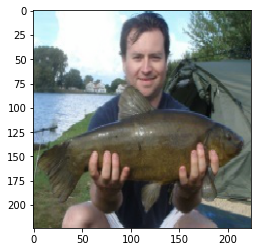

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

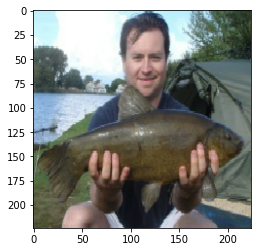

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

5.185604e-06

## Receptive field:

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  for y_step in range(config.input_shape[0] // shift):
    curr = np.zeros((1, *config.input_shape))
    curr[:, x_step*shift:x_step*shift + size, y_step*shift:y_step*shift + size,  :] = 1.

    curr = tf.convert_to_tensor(curr, dtype=config.dtype)
    curr_logits, _ = model(curr, training=False)
    if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
      print("Coordinates with zero diff: x - ", x_step*shift, " y - ", y_step*shift)
      break

Coordinates with zero diff: x -  0  y -  36
Coordinates with zero diff: x -  4  y -  36
Coordinates with zero diff: x -  8  y -  36
Coordinates with zero diff: x -  12  y -  36
Coordinates with zero diff: x -  16  y -  36
Coordinates with zero diff: x -  20  y -  36
Coordinates with zero diff: x -  24  y -  36
Coordinates with zero diff: x -  28  y -  36
Coordinates with zero diff: x -  32  y -  36
Coordinates with zero diff: x -  36  y -  0
Coordinates with zero diff: x -  40  y -  0
Coordinates with zero diff: x -  44  y -  0
Coordinates with zero diff: x -  48  y -  0
Coordinates with zero diff: x -  52  y -  0
Coordinates with zero diff: x -  56  y -  0
Coordinates with zero diff: x -  60  y -  0
Coordinates with zero diff: x -  64  y -  0
Coordinates with zero diff: x -  68  y -  0
Coordinates with zero diff: x -  72  y -  0
Coordinates with zero diff: x -  76  y -  0
Coordinates with zero diff: x -  80  y -  0
Coordinates with zero diff: x -  84  y -  0
Coordinates with zero diff

Таким образом, мы видим, что рецептивное поле для первых 10 логитов - это примерно левый верхний угол размером 32 на 32 пикселя. Попробуем увеличить глубину сети:

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 50)
  config.add_hparam("n_res", [1] * 50)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

Coordinates with zero diff: x -  92  y -  92
Coordinates with zero diff: x -  96  y -  96
Coordinates with zero diff: x -  100  y -  100
Coordinates with zero diff: x -  104  y -  104
Coordinates with zero diff: x -  108  y -  108
Coordinates with zero diff: x -  112  y -  112
Coordinates with zero diff: x -  116  y -  116
Coordinates with zero diff: x -  120  y -  120
Coordinates with zero diff: x -  124  y -  124
Coordinates with zero diff: x -  128  y -  128
Coordinates with zero diff: x -  132  y -  132
Coordinates with zero diff: x -  136  y -  136
Coordinates with zero diff: x -  140  y -  140
Coordinates with zero diff: x -  144  y -  144
Coordinates with zero diff: x -  148  y -  148
Coordinates with zero diff: x -  152  y -  152
Coordinates with zero diff: x -  156  y -  156
Coordinates with zero diff: x -  160  y -  160
Coordinates with zero diff: x -  164  y -  164
Coordinates with zero diff: x -  168  y -  168
Coordinates with zero diff: x -  172  y -  172
Coordinates with 

Таким образом, с данной глубиной сети рецептивное поле - примерно половина изображения. При увеличении глубины сети возникают очень большие погрешности и сеть перестает быть обратимой, что показано ниже.

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

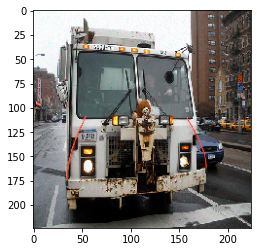

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x =  model.get_x(logits, nuisance)
plt.imshow(res_x);

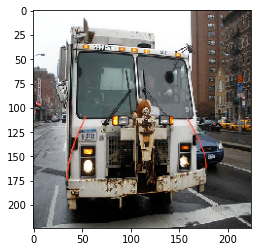

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.22431368

## Space to depth:

Воспользуемся методом tf.nn.space_to_depth для увеличения рецептивного поля и для сохранения обратимости модели:

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 6)
  config.add_hparam("n_res", [3] * 6)
  config.add_hparam("ratio", [2, 2, 2, 1, 1, 1])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 0)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

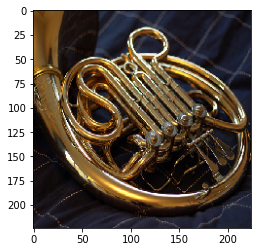

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

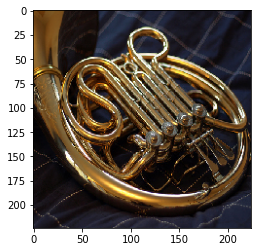

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.0026847273

Модель достаточно обратима.

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

РецеРецептивное поле - всё изображение

## LRFinder

In [0]:
tqdm.tqdm._instances.clear()

In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 80%|████████  | 237/296 [20:33<05:05,  5.18s/it]

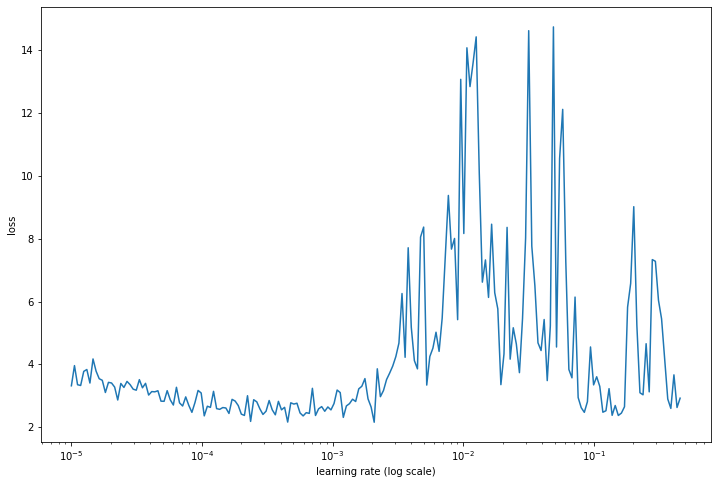

In [0]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

## Graphics

Epoch:  9
Training loss over epoch: 0.9667631387710571, Training acc over epoch: 0.7499207854270935
Val loss over epoch: 2.3217992782592773, Val acc over epoch: 0.24305732548236847


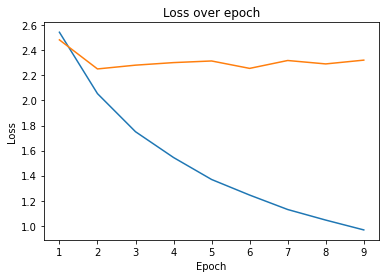

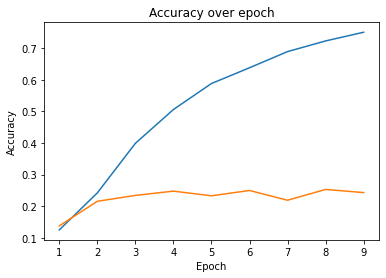

KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense.hdf5")

Явное переобучение, попробуем немного другую конфигурацию с меньшим числом обучаемых параметров

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


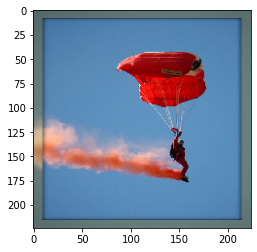

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

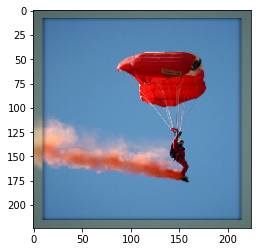

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.00095671415

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 85%|████████▌ | 252/296 [16:28<02:51,  3.90s/it]

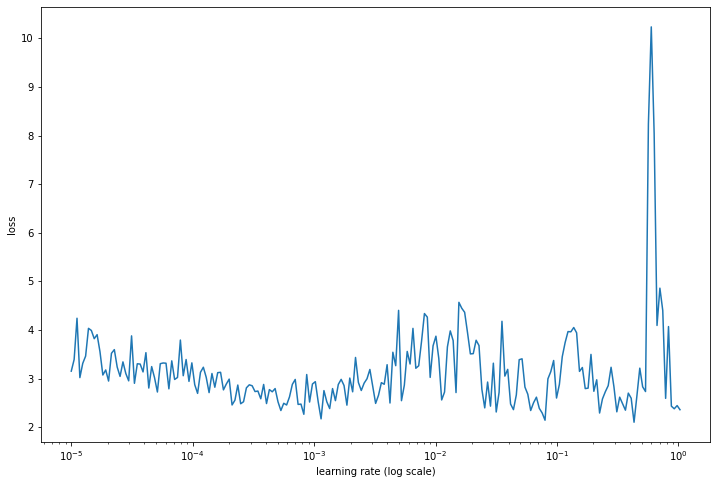

In [0]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  7
Training loss over epoch: 1.8913116455078125, Training acc over epoch: 0.3622346520423889
Val loss over epoch: 2.1520400047302246, Val acc over epoch: 0.23235668241977692


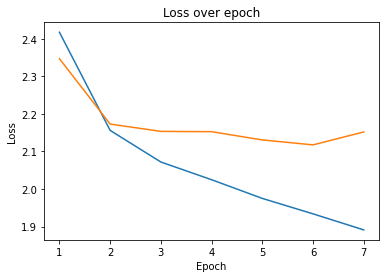

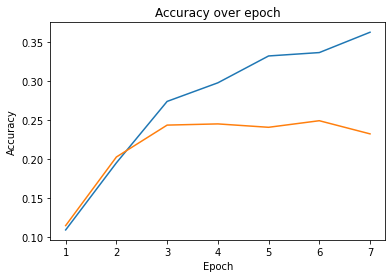

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

Epoch:  14
Training loss over epoch: 1.4036531448364258, Training acc over epoch: 0.593304455280304
Val loss over epoch: 2.243724822998047, Val acc over epoch: 0.2315923571586609


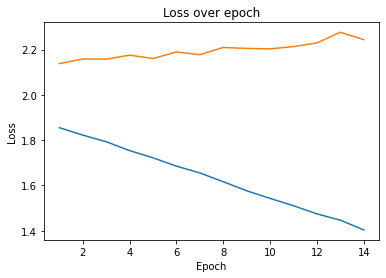

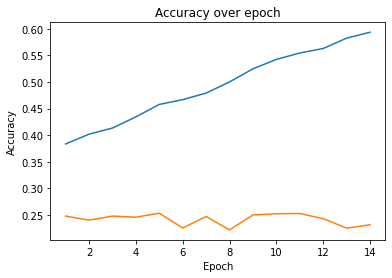

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_second.hdf5")

Пока что все равно сильное переобучение остается.

Посчитаем выходы сети, а также выведем веса:

In [0]:
def count_output_stats(model, data):
    print('{:41} {:7} {:7} {:7}'.format("Layer_name", "Mean", "Std", "AbsMax"))
    x = model.layers[0](data)
    print('{:40} {: .4f} {: .4f} {: .4f}'.format(model.layers[0].name, np.mean(x), np.std(x), np.max(np.abs(x))))

    for i, layer in enumerate(model.layers[1:-1]):
      if config.ratio[i] > 1:
        x = tf.nn.space_to_depth(x, config.ratio[i])
      x = layer(x)
      print('{:40} {: .4f} {: .4f} {: .4f}'.format(layer.name, np.mean(x), np.std(x), np.max(np.abs(x))))
    
    x = model.layers[-1](x)
    print('{:40} {: .4f} {: .4f} {: .4f}'.format(model.layers[-1].name, np.mean(x), np.std(x), np.max(np.abs(x))))

In [0]:
x_batch_train, y_batch_train = train.next()
count_output_stats(model, x_batch_train)

Layer_name                                Mean    Std     AbsMax 
init                                      0.0383  0.2004  0.9090
rev_block                                 0.0540  0.7629  7.2161
rev_block_1                               0.1175  1.0884  14.5938
rev_block_2                               0.1719  1.3505  21.8567
rev_block_3                               0.1917  1.5440  23.7656
rev_block_4                               0.2086  1.7186  29.2781
rev_block_5                               0.2192  1.8292  34.5282
rev_block_6                               0.2059  1.9709  34.9771
rev_block_7                               0.1846  2.0702  34.2742
rev_block_8                               0.1567  2.1749  37.3238
rev_block_9                               0.1089  2.2818  44.8782
rev_block_10                              0.1044  2.3746  45.0847
rev_block_11                              0.1159  2.4653  51.0374
rev_block_12                              0.1188  2.5504  55.1833
rev_block_13

In [0]:
def count_weights_stats(model):
    print('{:41} {:7} {:7} {:7}'.format("Layer_name", "Mean", "Std", "AbsMax"))
    for layer in model.layers:
      for weights in layer.weights:
        name = weights.name
        weights = weights.numpy()
        print('{:40} {: .4f} {: .4f} {: .4f}'.format(name, np.mean(weights), np.std(weights), np.max(np.abs(weights))))

In [0]:
count_weights_stats(model)

Layer_name                                Mean    Std     AbsMax 
conv2d/kernel:0                           0.0293  0.2504  0.4149
batch_normalization/gamma:0               1.0000  0.0036  1.0106
batch_normalization/beta:0               -0.0003  0.0051  0.0115
batch_normalization/moving_mean:0         0.0385  0.1619  0.4029
batch_normalization/moving_variance:0     0.0126  0.0137  0.0640
conv2d_1/kernel:0                        -0.0004  0.0420  0.0846
batch_normalization_1/gamma:0             1.0000  0.0037  1.0092
batch_normalization_1/beta:0             -0.0002  0.0037  0.0118
batch_normalization_1/moving_mean:0      -0.0690  0.4202  0.8508
batch_normalization_1/moving_variance:0   0.3475  0.2435  1.5265
conv2d_2/kernel:0                         0.0001  0.0419  0.0848
batch_normalization_2/gamma:0             1.0000  0.0030  1.0082
batch_normalization_2/beta:0              0.0001  0.0027  0.0061
batch_normalization_2/moving_mean:0       0.0525  0.3941  1.0527
batch_normalization_2/mo

### Новая конфигурация

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 16)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
model.summary()

Model: "rev_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Sequential)            (None, 224, 224, 16)      48        
_________________________________________________________________
rev_block_44 (RevBlock)      multiple                  37376     
_________________________________________________________________
rev_block_45 (RevBlock)      multiple                  37376     
_________________________________________________________________
rev_block_46 (RevBlock)      multiple                  37376     
_________________________________________________________________
rev_block_47 (RevBlock)      multiple                  37376     
_________________________________________________________________
rev_block_48 (RevBlock)      multiple                  37376     
_________________________________________________________________
rev_block_49 (RevBlock)      multiple                  37

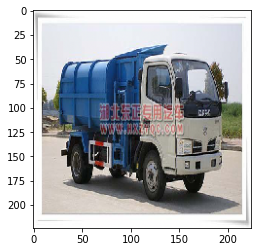

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

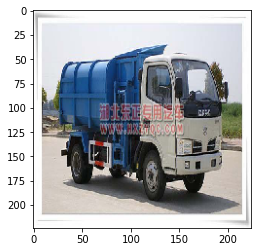

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.00018936396

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 89%|████████▊ | 262/296 [09:46<01:15,  2.21s/it]

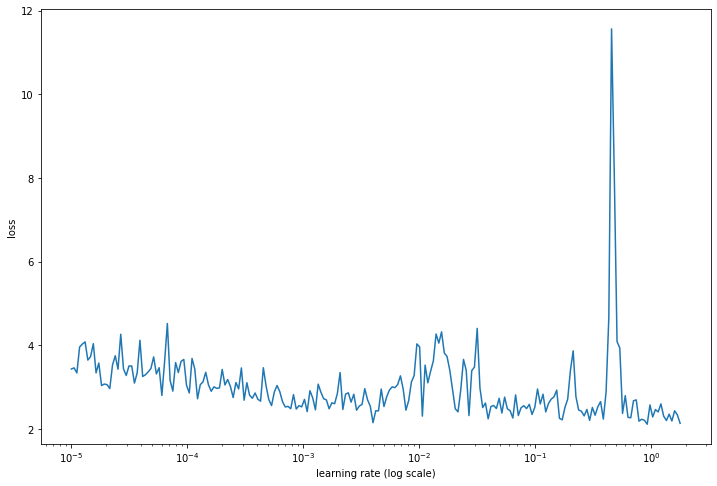

In [0]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  13
Training loss over epoch: 1.8161683082580566, Training acc over epoch: 0.407857209444046
Val loss over epoch: 2.139409065246582, Val acc over epoch: 0.24815286695957184


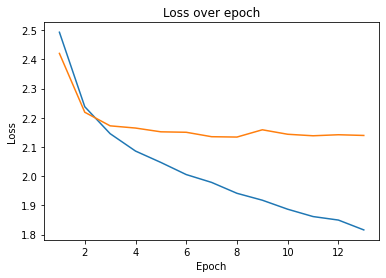

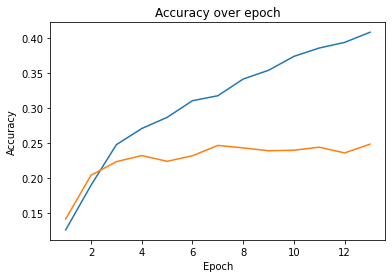

KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_third.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_third.hdf5")

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 16)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([1] * 7 + [2] + [1] * 6 + [2] + [1] * 7))
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
model.summary()

Model: "rev_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Sequential)            (None, 224, 224, 16)      48        
_________________________________________________________________
rev_block_88 (RevBlock)      multiple                  2432      
_________________________________________________________________
rev_block_89 (RevBlock)      multiple                  2432      
_________________________________________________________________
rev_block_90 (RevBlock)      multiple                  2432      
_________________________________________________________________
rev_block_91 (RevBlock)      multiple                  2432      
_________________________________________________________________
rev_block_92 (RevBlock)      multiple                  2432      
_________________________________________________________________
rev_block_93 (RevBlock)      multiple                  24

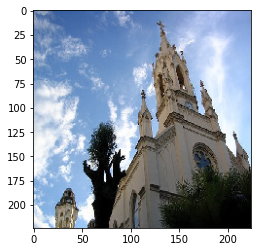

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

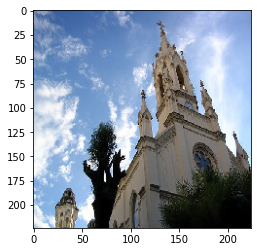

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.0003643036

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

Coordinates with zero diff: x -  184  y -  184
Coordinates with zero diff: x -  188  y -  188
Coordinates with zero diff: x -  192  y -  192
Coordinates with zero diff: x -  196  y -  196
Coordinates with zero diff: x -  200  y -  200
Coordinates with zero diff: x -  204  y -  204
Coordinates with zero diff: x -  208  y -  208
Coordinates with zero diff: x -  212  y -  212
Coordinates with zero diff: x -  216  y -  216
Coordinates with zero diff: x -  220  y -  220


In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 83%|████████▎ | 247/296 [10:15<02:03,  2.52s/it]

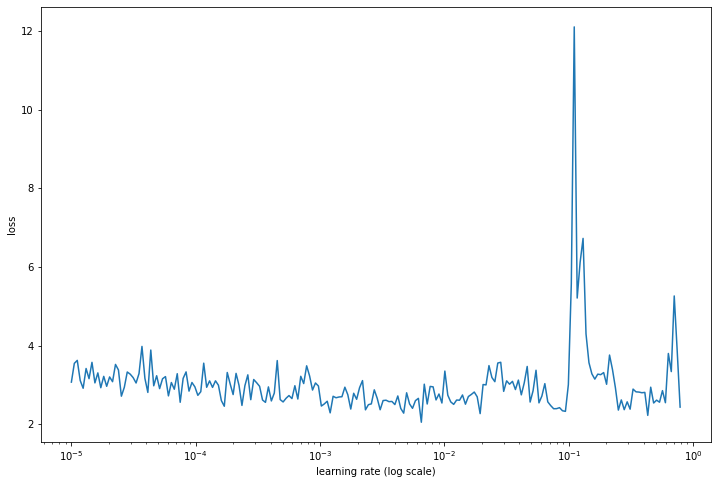

In [0]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  9
Training loss over epoch: 1.9289870262145996, Training acc over epoch: 0.33678320050239563
Val loss over epoch: 2.1200504302978516, Val acc over epoch: 0.2466242015361786


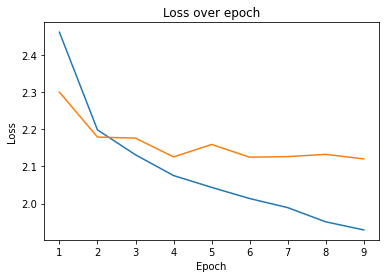

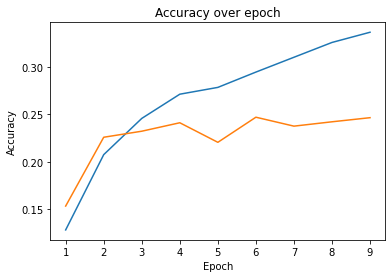

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_fourth.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_fourth.hdf5")

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 21))
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
model.summary()

Model: "rev_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Sequential)            (None, 224, 224, 32)      96        
_________________________________________________________________
rev_block (RevBlock)         multiple                  148480    
_________________________________________________________________
rev_block_1 (RevBlock)       multiple                  148480    
_________________________________________________________________
rev_block_2 (RevBlock)       multiple                  148480    
_________________________________________________________________
rev_block_3 (RevBlock)       multiple                  148480    
_________________________________________________________________
rev_block_4 (RevBlock)       multiple                  148480    
_________________________________________________________________
rev_block_5 (RevBlock)       multiple                  1484

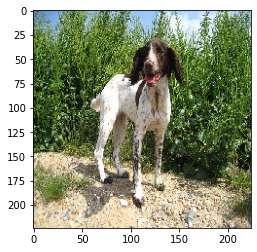

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

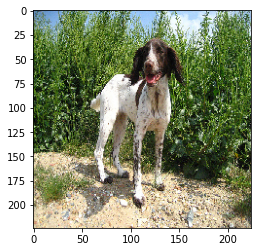

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.0025376081

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

Coordinates with zero diff: x -  144  y -  144
Coordinates with zero diff: x -  148  y -  148
Coordinates with zero diff: x -  152  y -  152
Coordinates with zero diff: x -  156  y -  156
Coordinates with zero diff: x -  160  y -  160
Coordinates with zero diff: x -  164  y -  164
Coordinates with zero diff: x -  168  y -  168
Coordinates with zero diff: x -  172  y -  172
Coordinates with zero diff: x -  176  y -  176
Coordinates with zero diff: x -  180  y -  180
Coordinates with zero diff: x -  184  y -  184
Coordinates with zero diff: x -  188  y -  188
Coordinates with zero diff: x -  192  y -  192
Coordinates with zero diff: x -  196  y -  196
Coordinates with zero diff: x -  200  y -  200
Coordinates with zero diff: x -  204  y -  204
Coordinates with zero diff: x -  208  y -  208
Coordinates with zero diff: x -  212  y -  212
Coordinates with zero diff: x -  216  y -  216
Coordinates with zero diff: x -  220  y -  220


In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 83%|████████▎ | 246/296 [26:37<05:28,  6.56s/it]

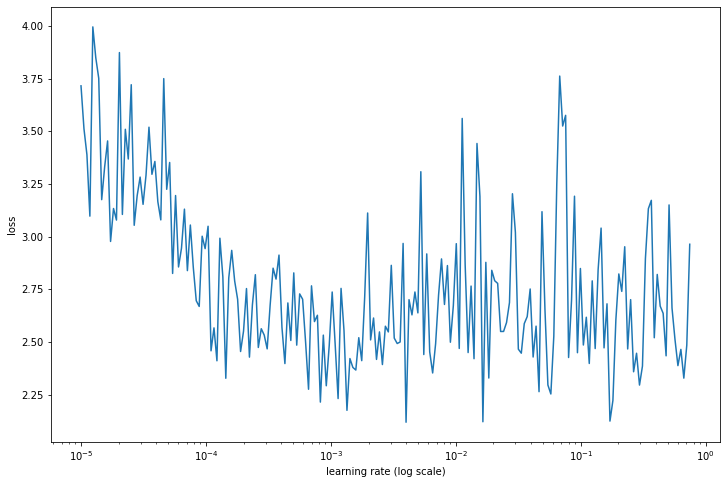

In [0]:
n_skip_beginning = 0
n_skip_end = 40

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  5
Training loss over epoch: 2.011624813079834, Training acc over epoch: 0.309853196144104
Val loss over epoch: 2.140672445297241, Val acc over epoch: 0.24509553611278534


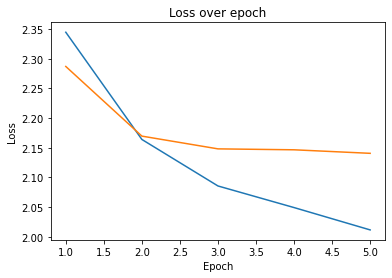

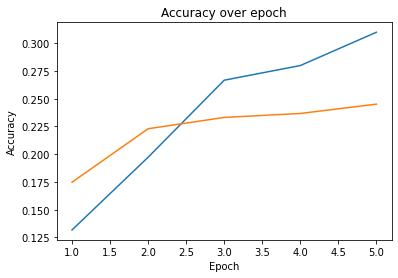

KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_fourth.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_fourth.hdf5")

### Аугментация

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 16)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen_train = ImageDataGenerator(rescale=1/255,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    channel_shift_range=50,
                                    rotation_range=30,
                                    horizontal_flip=True)

imagegen_val = ImageDataGenerator(rescale=1/255)

train = imagegen_train.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen_val.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


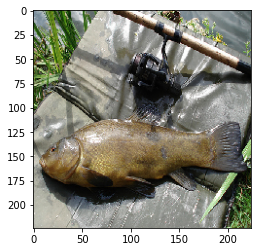

In [0]:
x, y = val.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

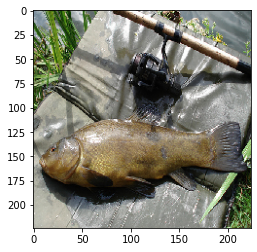

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.0016509295

Epoch:  7
Training loss over epoch: 2.1611907482147217, Training acc over epoch: 0.2283240109682083
Val loss over epoch: 2.1520702838897705, Val acc over epoch: 0.2170700579881668


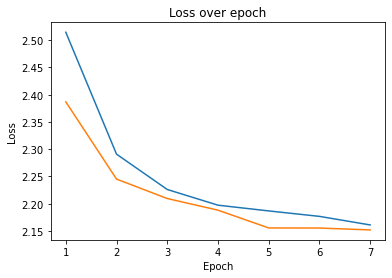

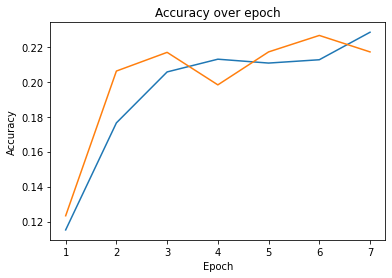

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_augm_first.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_first.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_first.hdf5")

Epoch:  4
Training loss over epoch: 2.1435225009918213, Training acc over epoch: 0.23170346021652222
Val loss over epoch: 2.106503963470459, Val acc over epoch: 0.23898088932037354


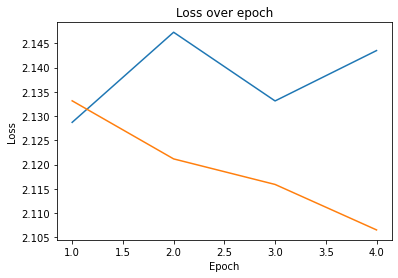

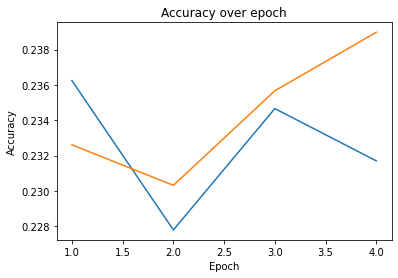

KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output

max_val_acc = 0.2170700579881668

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_augm_first.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_first.hdf5")

### Меньше аугментации

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 16)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)
  
  return config

In [0]:
config = get_hparams_imagenette()

imagegen_train = ImageDataGenerator(rescale=1/255,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    channel_shift_range=20,
                                    rotation_range=20)

imagegen_val = ImageDataGenerator(rescale=1/255)

train = imagegen_train.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen_val.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Epoch:  11
Training loss over epoch: 2.110487461090088, Training acc over epoch: 0.25134649872779846
Val loss over epoch: 2.1113505363464355, Val acc over epoch: 0.2466242015361786


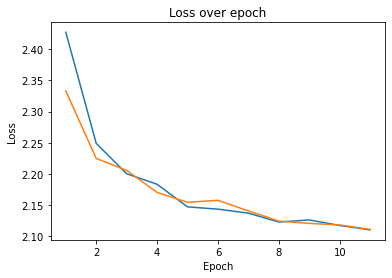

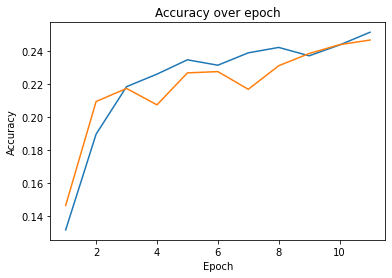

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_augm_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_second.hdf5")

### Более глубокая сеть с аугментацией

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 22)
  config.add_hparam("ratio", ([2] + [1] * 10) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)

  return config

In [0]:
config = get_hparams_imagenette()

imagegen_train = ImageDataGenerator(rescale=1/255,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    channel_shift_range=20,
                                    rotation_range=20)

imagegen_val = ImageDataGenerator(rescale=1/255)

train = imagegen_train.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen_val.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


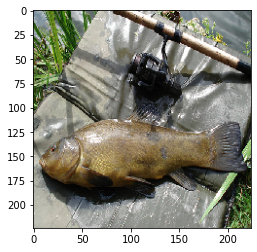

In [0]:
x, y = val.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

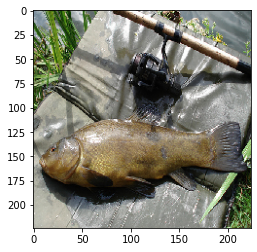

In [0]:
plt.imshow(x[0])

In [0]:
np.max(abs(res_x - x0[0]))

0.00030204654

Epoch:  5
Training loss over epoch: 2.1529390811920166, Training acc over epoch: 0.23550532758235931
Val loss over epoch: 2.140791416168213, Val acc over epoch: 0.23949044942855835


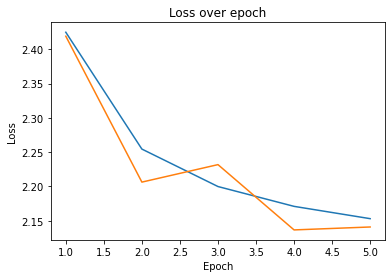

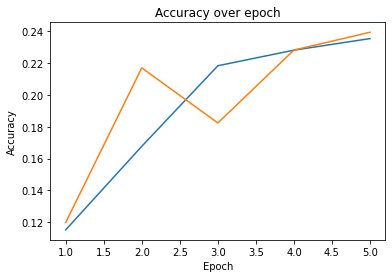

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_augm_third.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_third.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_third.hdf5")

Epoch:  10
Training loss over epoch: 2.0907464027404785, Training acc over epoch: 0.2545147240161896
Val loss over epoch: 2.0824503898620605, Val acc over epoch: 0.2499363124370575


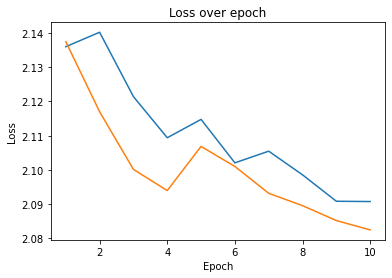

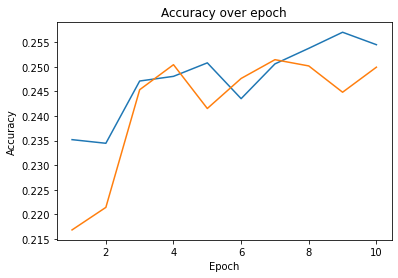

In [0]:
from IPython.display import clear_output

max_val_acc = 0.23949044942855835

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_augm_third.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_augm_third.hdf5")

# Равномерное взятие логитов

До этого в качестве логитов брались первые 10 чисел выхода, что сильно уменьшало рецептивное поле. Поэтому сейчас мы попробуем брать 10 чисел равномерно на всем выходе, чтобы увеличить рецептивное поле не увеличив резко число параметров

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 12)
  config.add_hparam("ratio", ([2] + [1] * 5) * 2)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", True)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("with_dense", True)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)

  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


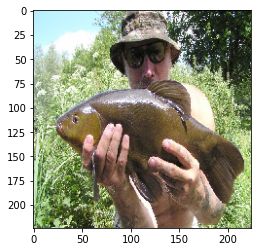

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

res_x = model.get_x(logits, nuisance)
plt.imshow(res_x);

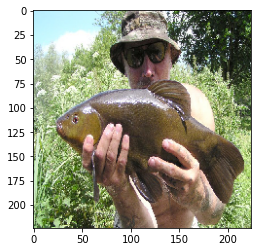

In [0]:
plt.imshow(x0[0])

In [0]:
np.max(abs(res_x - x0[0]))

1.013279e-06

In [0]:
model.summary()

Model: "rev_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Sequential)            (None, 224, 224, 32)      96        
_________________________________________________________________
rev_block_58 (RevBlock)      multiple                  9792      
_________________________________________________________________
rev_block_59 (RevBlock)      multiple                  9792      
_________________________________________________________________
rev_block_60 (RevBlock)      multiple                  9792      
_________________________________________________________________
rev_block_61 (RevBlock)      multiple                  9792      
_________________________________________________________________
rev_block_62 (RevBlock)      multiple                  9792      
_________________________________________________________________
rev_block_63 (RevBlock)      multiple                  97

In [0]:
zeros = np.zeros((1, *config.input_shape))
zeros = tf.convert_to_tensor(zeros, dtype=config.dtype)
zeros_logits, _ = model(zeros, training=False)

shift = 4
size = 10
for x_step in range(config.input_shape[0] // shift):
  curr = np.zeros((1, *config.input_shape))
  curr[:, x_step*shift:x_step*shift + size, x_step*shift:x_step*shift + size,  :] = 1.

  curr = tf.convert_to_tensor(curr, dtype=config.dtype)
  curr_logits, _ = model(curr, training=False)
  if np.sum(np.abs(zeros_logits.numpy() - curr_logits.numpy())) == 0:
    print("Coordinates with zero diff: x - ", x_step*shift, " y - ", x_step*shift)

Рецептивное поле - все изображение

In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 71%|███████▏  | 211/296 [06:39<02:40,  1.89s/it]

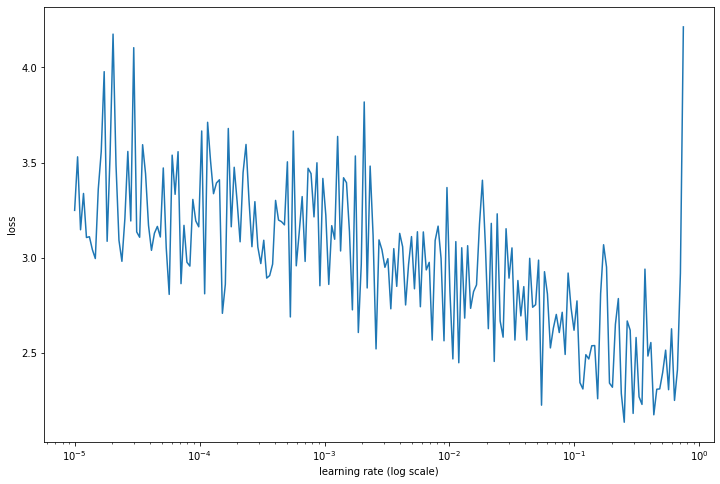

In [0]:
n_skip_beginning = 0
n_skip_end = 5

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  13
Training loss over epoch: 1.703397274017334, Training acc over epoch: 0.40806844830513
Val loss over epoch: 1.8313591480255127, Val acc over epoch: 0.35464969277381897


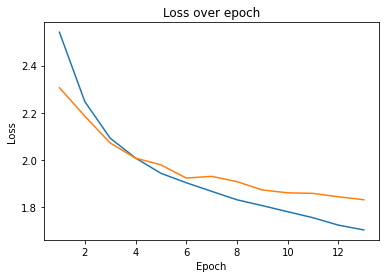

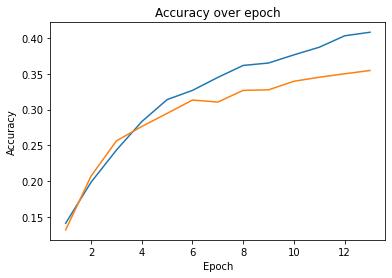

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform.hdf5")

Epoch:  20
Training loss over epoch: 1.2558101415634155, Training acc over epoch: 0.5666912794113159
Val loss over epoch: 1.8951399326324463, Val acc over epoch: 0.37783440947532654


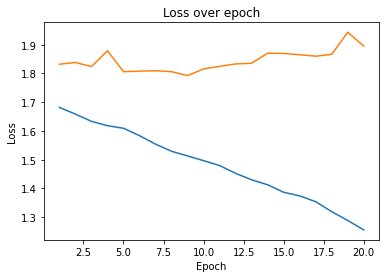

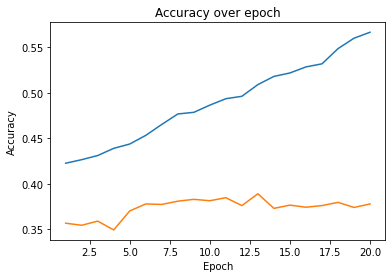

In [0]:
from IPython.display import clear_output

max_val_acc = 0.35464969277381897

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform.hdf5")

# Другая архитектура

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 12)
  config.add_hparam("ratio", ([2] + [1] * 3) * 3)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", True)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("with_dense", True)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)

  return config

In [0]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [0]:
model.build((1, 224, 224, 3))
model.summary()

Model: "rev_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Sequential)            (None, 224, 224, 32)      96        
_________________________________________________________________
rev_block (RevBlock)         multiple                  9792      
_________________________________________________________________
rev_block_1 (RevBlock)       multiple                  9792      
_________________________________________________________________
rev_block_2 (RevBlock)       multiple                  9792      
_________________________________________________________________
rev_block_3 (RevBlock)       multiple                  9792      
_________________________________________________________________
rev_block_4 (RevBlock)       multiple                  35904     
_________________________________________________________________
rev_block_5 (RevBlock)       multiple                  3590

In [0]:
import tensorflow.keras.backend as K
import math
import tqdm 

start_lr = 0.00001
end_lr = 100
max_val_acc = None
lr = start_lr
lr_mult = (end_lr / start_lr) ** (1 / int(np.ceil(train.samples / train.batch_size)))
lrs = []
losses = []
best_loss = 1e9

optimizer = tf.keras.optimizers.SGD(learning_rate=start_lr)

for step in tqdm.trange(int(np.ceil(train.samples / train.batch_size))):
    x_batch_train, y_batch_train = train.next()

    grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
    optimizer.apply_gradients(zip(grads, vars_))

    lrs.append(lr)
    losses.append(loss)

    if math.isnan(loss) or loss > best_loss * 1000:
        break
    
    if loss < best_loss:
        best_loss = loss

    lr *= lr_mult
    K.set_value(optimizer.lr, lr)

 69%|██████▉   | 205/296 [09:11<04:06,  2.71s/it]

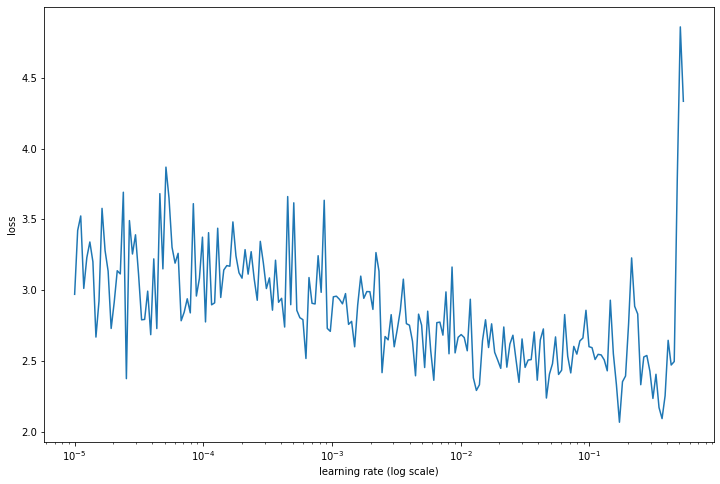

In [0]:
n_skip_beginning = 0
n_skip_end = 5

plt.figure(figsize=(12, 8))
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")
x = lrs[n_skip_beginning:-n_skip_end]
y = losses[n_skip_beginning:-n_skip_end]
plt.plot(x, y)
plt.xscale('log')

Epoch:  20
Training loss over epoch: 1.3289496898651123, Training acc over epoch: 0.5433520078659058
Val loss over epoch: 1.803661584854126, Val acc over epoch: 0.40254777669906616


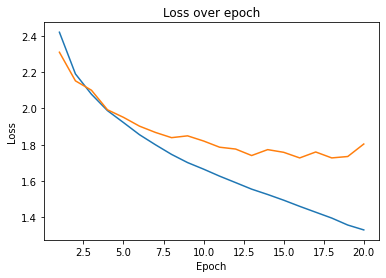

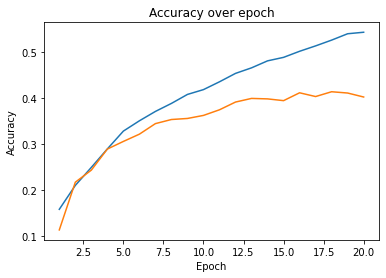

In [0]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second.hdf5")

Epoch:  20
Training loss over epoch: 0.4309800863265991, Training acc over epoch: 0.8608089685440063
Val loss over epoch: 2.535644769668579, Val acc over epoch: 0.42675158381462097


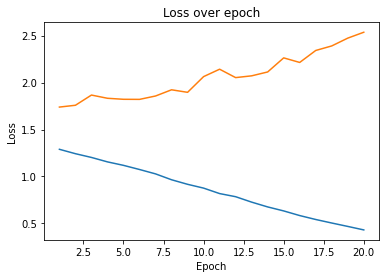

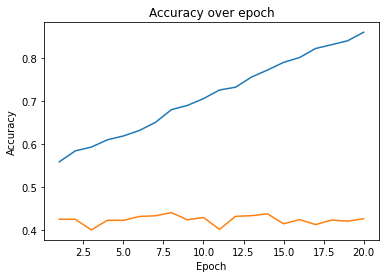

In [0]:
from IPython.display import clear_output

max_val_acc = 0.40254777669906616

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second.hdf5")

# Добавиим аугментации

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 12)
  config.add_hparam("ratio", ([2] + [1] * 3) * 3)
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", True)
  config.add_hparam("fused", True)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("with_dense", True)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 1e-4)

  return config

In [4]:
config = get_hparams_imagenette()

imagegen_train = ImageDataGenerator(rescale=1/255,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    channel_shift_range=20,
                                    rotation_range=20)

imagegen_val = ImageDataGenerator(rescale=1/255)

train = imagegen_train.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen_val.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Epoch:  3
Training loss over epoch: 2.1296956539154053, Training acc over epoch: 0.22969689965248108
Val loss over epoch: 2.124361753463745, Val acc over epoch: 0.23006369173526764


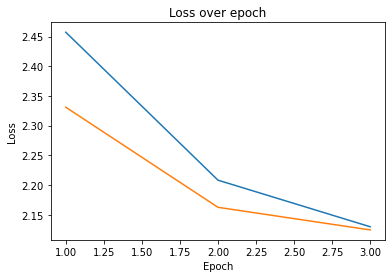

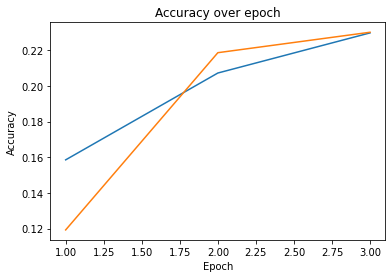

KeyboardInterrupt: ignored

In [15]:
from IPython.display import clear_output

max_val_acc = None

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 1.686060905456543, Training acc over epoch: 0.42158621549606323
Val loss over epoch: 1.5786901712417603, Val acc over epoch: 0.4614012837409973


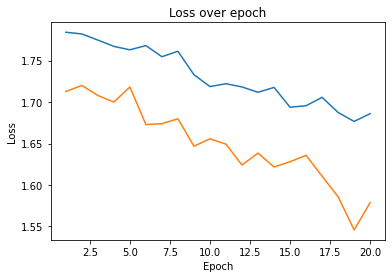

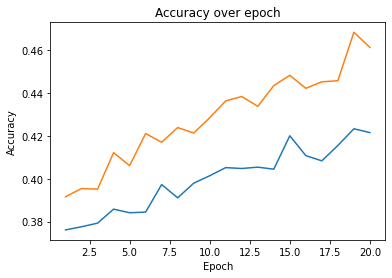

In [7]:
from IPython.display import clear_output

max_val_acc = 0.3824203908443451

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,  momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  6
Training loss over epoch: 1.5991652011871338, Training acc over epoch: 0.4546414613723755
Val loss over epoch: 1.4906948804855347, Val acc over epoch: 0.4945223033428192


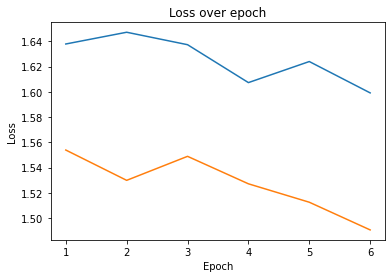

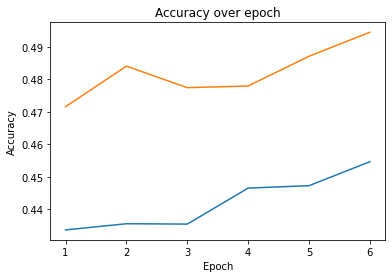

In [0]:
from IPython.display import clear_output

max_val_acc = 0.4614012837409973

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 1.3649885654449463, Training acc over epoch: 0.534903347492218
Val loss over epoch: 1.3245245218276978, Val acc over epoch: 0.5696815252304077


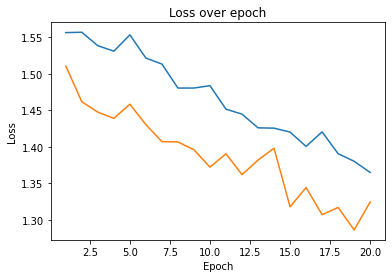

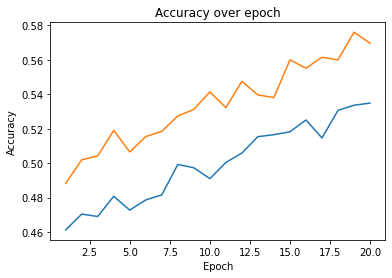

In [17]:
from IPython.display import clear_output

max_val_acc = 0.4614012837409973

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 1.2379577159881592, Training acc over epoch: 0.5861231088638306
Val loss over epoch: 1.1480488777160645, Val acc over epoch: 0.631337583065033


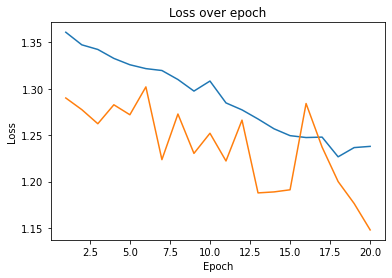

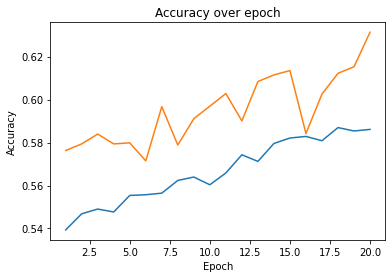

In [7]:
from IPython.display import clear_output

max_val_acc = 0.5696815252304077

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 1.1118839979171753, Training acc over epoch: 0.6299503445625305
Val loss over epoch: 1.109040379524231, Val acc over epoch: 0.6496815085411072


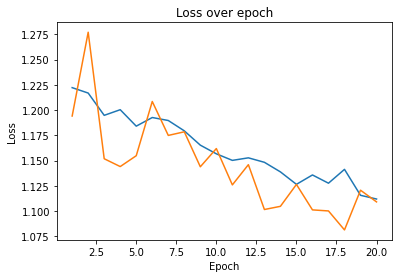

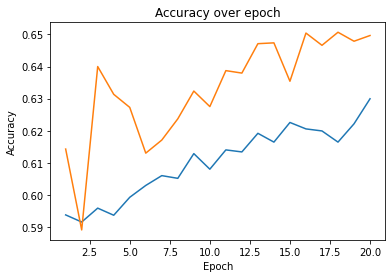

In [9]:
from IPython.display import clear_output

max_val_acc = 0.631337583065033

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 1.0333385467529297, Training acc over epoch: 0.6540289521217346
Val loss over epoch: 1.054447054862976, Val acc over epoch: 0.668789803981781


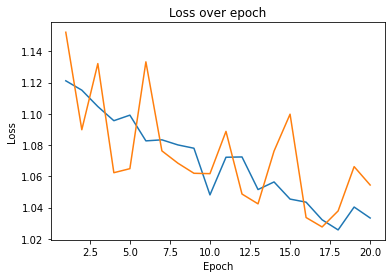

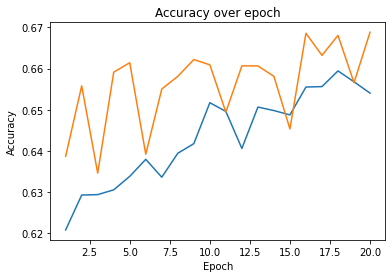

In [14]:
from IPython.display import clear_output

max_val_acc = 0.6496815085411072

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

Epoch:  20
Training loss over epoch: 0.9514644742012024, Training acc over epoch: 0.6820150017738342
Val loss over epoch: 1.0277801752090454, Val acc over epoch: 0.6789808869361877


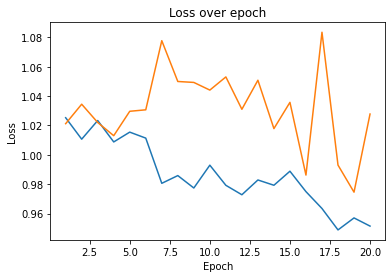

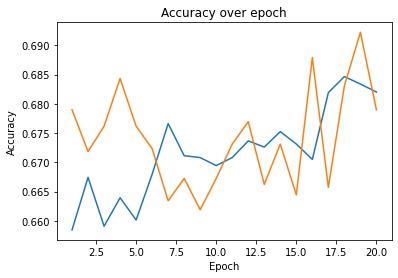

In [7]:
from IPython.display import clear_output

max_val_acc = 0.668789803981781

train_losses = []
val_losses = []

train_acc = []
val_acc = []

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss, logits = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    clear_output(True)
    print('Epoch: ', epoch + 1)
    print('Training loss over epoch: %s, Training acc over epoch: %s' % (float(train_mean_loss.result()), 
                                                                         float(train_acc_metric.result())))
    print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                               float(val_acc_metric.result())))

    train_losses.append(train_mean_loss.result())
    val_losses.append(val_mean_loss.result())

    plt.plot(range(1, epoch + 2), train_losses)
    plt.plot(range(1, epoch + 2), val_losses)
    plt.title("Loss over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    train_acc.append(train_acc_metric.result())
    val_acc.append(val_acc_metric.result())

    plt.plot(range(1, epoch + 2), train_acc)
    plt.plot(range(1, epoch + 2), val_acc)
    plt.title("Accuracy over epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")
        max_val_acc = float(val_acc_metric.result())

    model.save_weights("drive/My Drive/Диплом/curr_revnet_without_dense_uniform_second_augm.hdf5")

In [0]:
model.load_weights("drive/My Drive/Диплом/revnet_without_dense_uniform_second_augm.hdf5")

In [7]:
val_mean_loss = tf.keras.metrics.Mean()

val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step in range(int(np.ceil(val.samples / val.batch_size))):
    x_batch_val, y_batch_val = val.next()

    logits, _ = model(x_batch_val, training=False)
    loss = model.compute_loss(logits=logits, labels=y_batch_val)

    val_acc_metric(y_batch_val, logits)
    val_mean_loss(loss)

print('Val loss over epoch: %s, Val acc over epoch: %s' % (float(val_mean_loss.result()),
                                                            float(val_acc_metric.result())))

Val loss over epoch: 0.9745746850967407, Val acc over epoch: 0.6922292709350586


### Атака

In [10]:
test = imagegen_val.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=True, batch_size=1, target_size=(224, 224))

Found 3925 images belonging to 10 classes.


In [0]:
def choose_images(model, img_gen=None, threshold=0.):
    while True:
      logit_img, logit_class = img_gen.next()
      nuisance_img, nuisance_class = img_gen.next()

      logit_img = tf.cast(logit_img, tf.float32)
      nuisance_img = tf.cast(nuisance_img, tf.float32)
      
      logit_class = int(logit_class[0])
      nuisance_class = int(nuisance_class[0])

      logit_logits, _ = model(logit_img, training=False)
      nuisance_logits, _ = model(nuisance_img, training=False)
      
      logit_logits = tf.nn.softmax(logit_logits).numpy()[0]
      nuisance_logits = tf.nn.softmax(nuisance_logits).numpy()[0]
      
      logit_pred = np.argmax(logit_logits)
      nuisance_pred = np.argmax(nuisance_logits)

      if logit_class == logit_pred and nuisance_class == nuisance_pred \
        and logit_pred != nuisance_pred and np.max(logit_logits) > threshold \
        and np.max(nuisance_logits) > threshold:
          break

    print("Logit image: ")
    print("Logits: ", logit_logits)
    print("Predicted: ", logit_pred)
    print("Real: ", logit_class)
    plt.imshow(logit_img[0])
    plt.show()

    print("Nuisance image: ")
    print("Logits: ", nuisance_logits)
    print("Predicted: ", nuisance_pred)
    print("Real: ", nuisance_class)
    plt.imshow(nuisance_img[0])
    plt.show()

    return logit_img, nuisance_img

Logit image: 
Logits:  [6.7376101e-04 7.3143882e-01 7.4546129e-02 5.8347844e-02 1.3945829e-02
 2.0138230e-02 2.9955246e-03 4.8038443e-03 7.9457909e-02 1.3652109e-02]
Predicted:  1
Real:  1


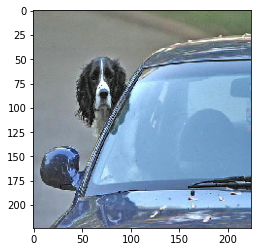

Nuisance image: 
Logits:  [2.6584785e-06 1.5909359e-06 1.9033230e-05 7.0361194e-04 6.7439705e-02
 1.2761999e-05 1.5392676e-02 4.6136146e-03 2.0743513e-03 9.0974003e-01]
Predicted:  9
Real:  9


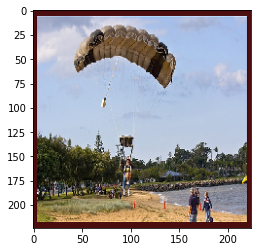

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [1.5291155e-07 4.3707800e-07 1.0168161e-05 1.3076726e-03 1.0819446e-01
 3.0500481e-05 1.5227906e-02 1.0222977e-02 3.4099587e-04 8.6466473e-01]
Metameric class:  9


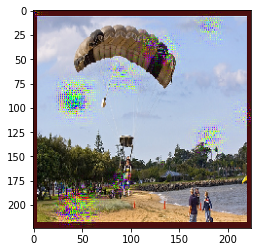


Logit image: 
Logits:  [1.1075529e-02 9.7162580e-01 4.0692754e-05 4.0274705e-03 9.5885675e-08
 4.7631597e-06 8.2917154e-07 3.3969748e-06 1.3216731e-02 4.6808777e-06]
Predicted:  1
Real:  1


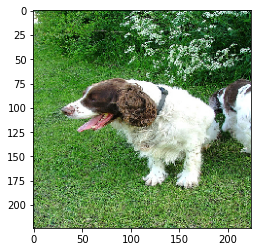

Nuisance image: 
Logits:  [1.6019199e-04 1.9711640e-04 4.0598833e-03 2.5727069e-02 1.0689336e-03
 8.5707201e-04 1.9737003e-02 9.1777343e-01 5.3702114e-04 2.9882357e-02]
Predicted:  7
Real:  7


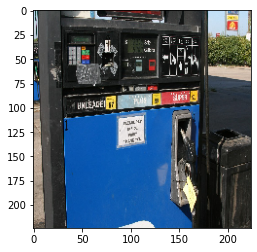

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [2.06089881e-05 1.17225580e-04 2.62827361e-05 2.59985309e-02
 4.25962702e-04 1.21123041e-03 1.01078048e-01 8.61857593e-01
 1.07290125e-05 9.25382692e-03]
Metameric class:  7


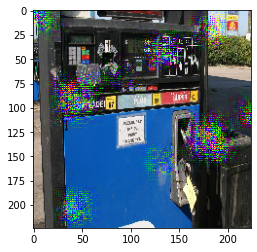


Logit image: 
Logits:  [3.6721210e-06 2.3964334e-05 9.7903675e-01 4.3588327e-03 1.4695686e-03
 1.2224440e-04 7.1572405e-03 2.3399559e-03 5.2486132e-03 2.3918090e-04]
Predicted:  2
Real:  2


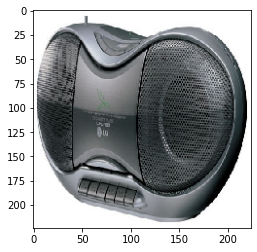

Nuisance image: 
Logits:  [9.4034404e-01 2.9085777e-03 3.6458417e-03 3.3344990e-03 4.6494696e-03
 4.1553646e-02 1.3129637e-04 8.1538816e-04 2.6041397e-03 1.3119254e-05]
Predicted:  0
Real:  0


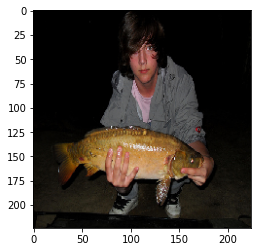

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [9.3800545e-04 2.2341400e-11 4.5185741e-05 8.6506651e-07 3.7538075e-09
 1.5389098e-08 1.0674509e-02 9.8829901e-01 1.7718274e-07 4.2238335e-05]
Metameric class:  7


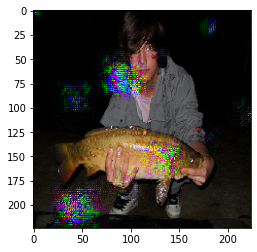


Logit image: 
Logits:  [6.4276173e-03 9.6017454e-04 2.9065509e-04 5.9497696e-03 8.2873479e-03
 9.7631276e-01 1.1866046e-04 1.6097020e-03 3.1818829e-05 1.1489076e-05]
Predicted:  5
Real:  5


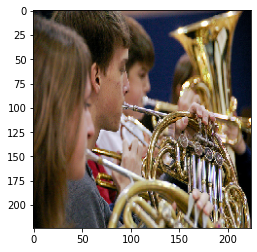

Nuisance image: 
Logits:  [1.0062062e-04 9.5423260e-05 1.7175862e-03 2.7946403e-02 7.7593297e-01
 4.2602750e-03 1.5076996e-01 2.7741935e-02 3.6320434e-04 1.1071626e-02]
Predicted:  4
Real:  4


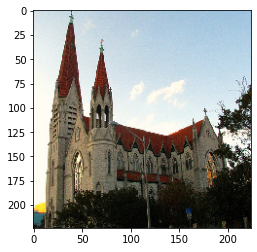

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [9.6325630e-14 9.3840873e-09 1.0238895e-04 4.0782488e-06 2.3425902e-05
 9.1135283e-10 9.9980599e-01 1.9110530e-05 8.1981213e-08 4.4821416e-05]
Metameric class:  6


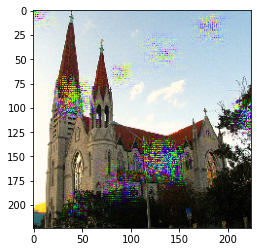


Logit image: 
Logits:  [9.4702145e-06 8.0504040e-05 9.6834344e-01 1.0285725e-02 8.9630776e-05
 4.5173251e-04 3.9994880e-04 1.7375793e-02 2.8028495e-03 1.6098328e-04]
Predicted:  2
Real:  2


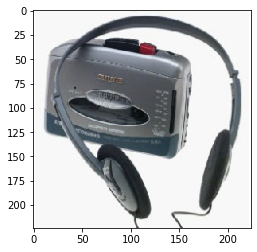

Nuisance image: 
Logits:  [4.6457894e-04 1.4820873e-03 5.6384504e-02 1.2290680e-02 7.4260505e-03
 5.5438071e-05 1.8366334e-03 8.0381671e-04 8.5799015e-01 6.1266061e-02]
Predicted:  8
Real:  8


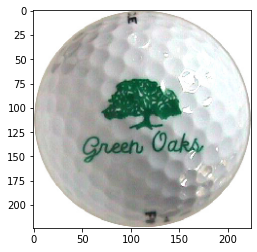

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [5.2711592e-05 4.9779228e-05 8.0741280e-01 3.0910036e-02 6.4348807e-03
 1.6602589e-04 4.3497715e-02 5.0521158e-02 3.1617615e-02 2.9337274e-02]
Metameric class:  2


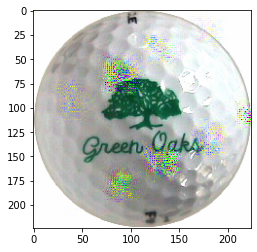


Logit image: 
Logits:  [5.9288682e-04 3.4595683e-02 6.6401036e-03 7.1977150e-01 9.5081739e-02
 1.3103226e-02 1.5924687e-02 6.2996455e-02 1.5990017e-02 3.5303727e-02]
Predicted:  3
Real:  3


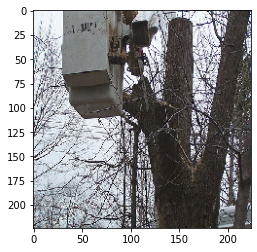

Nuisance image: 
Logits:  [1.2775895e-07 1.3894984e-06 3.3511864e-05 1.6809133e-04 3.1084996e-03
 6.2812637e-07 5.2235782e-04 5.8839138e-04 6.3912999e-03 9.8918581e-01]
Predicted:  9
Real:  9


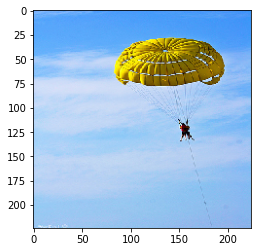

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [3.6950769e-09 2.3297127e-06 8.6716354e-05 1.4249605e-04 4.3163465e-05
 1.0763614e-08 4.8884947e-02 2.4962274e-04 2.0175485e-03 9.4857317e-01]
Metameric class:  9


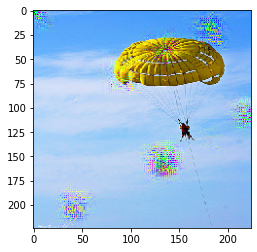


Logit image: 
Logits:  [1.0422296e-05 3.2182495e-04 2.0956772e-04 2.2597942e-03 2.8293463e-03
 1.6657243e-05 4.7433050e-03 3.8183650e-03 8.1233634e-03 9.7766739e-01]
Predicted:  9
Real:  9


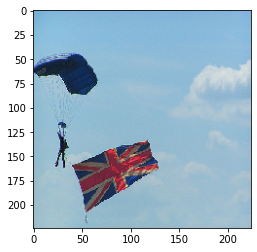

Nuisance image: 
Logits:  [1.4654517e-05 3.1786953e-05 4.8569571e-02 1.7103310e-03 2.5684563e-03
 2.2753241e-04 9.3031400e-01 1.4353282e-02 2.0119133e-04 2.0092251e-03]
Predicted:  6
Real:  6


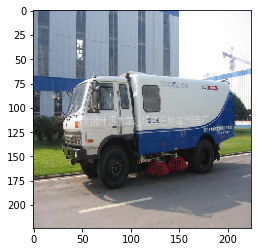

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [8.5229679e-12 6.9002283e-08 1.0695405e-01 1.9660389e-05 1.8680227e-06
 3.1215719e-10 8.5103768e-01 4.4215466e-03 1.6653024e-04 3.7398692e-02]
Metameric class:  6


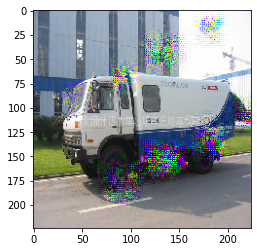


Logit image: 
Logits:  [7.5333676e-04 9.1052586e-01 7.7794623e-03 1.7216103e-02 1.1786097e-03
 4.0551264e-02 2.6083517e-05 5.0133344e-04 2.1242538e-02 2.2544240e-04]
Predicted:  1
Real:  1


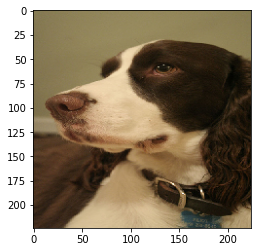

Nuisance image: 
Logits:  [1.6341637e-05 1.2460371e-05 2.0889265e-06 6.5242682e-05 1.6944237e-04
 9.9972636e-01 1.4653780e-08 7.9294168e-06 4.1075676e-08 6.9533561e-09]
Predicted:  5
Real:  5


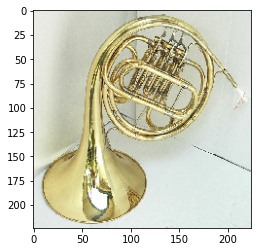

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [3.1092628e-03 2.3768649e-03 1.7033779e-05 7.7050161e-03 4.7985628e-02
 9.3861258e-01 3.1747793e-06 1.3342511e-04 5.1309926e-05 5.6986842e-06]
Metameric class:  5


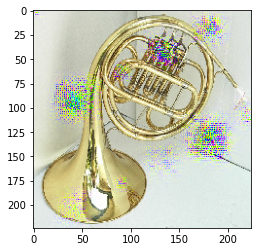


Logit image: 
Logits:  [6.3858470e-03 9.7396088e-01 3.0711258e-03 2.0936918e-03 8.1371414e-05
 3.9131413e-03 9.1365791e-06 4.2652551e-05 1.0429779e-02 1.2456975e-05]
Predicted:  1
Real:  1


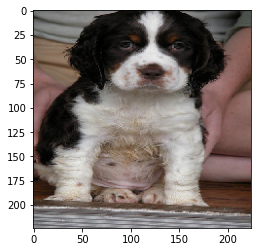

Nuisance image: 
Logits:  [2.4757566e-07 4.4261840e-05 2.0475173e-04 6.8002008e-03 7.5400221e-01
 2.3710600e-01 8.1556197e-04 9.9495787e-04 1.8303555e-06 2.9992820e-05]
Predicted:  4
Real:  4


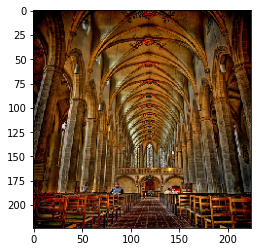

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [3.2796981e-06 8.0708237e-03 8.5229731e-05 3.4299430e-01 5.9093070e-01
 3.6035094e-02 3.5072924e-03 1.5782584e-02 2.5376544e-04 2.3368762e-03]
Metameric class:  4


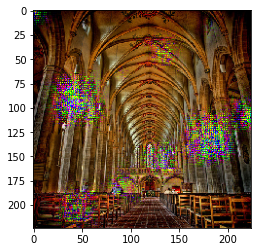


Logit image: 
Logits:  [4.98673398e-05 5.86444403e-05 1.09764405e-04 8.86778254e-03
 9.46121037e-01 1.06824078e-02 2.47198753e-02 4.81085340e-03
 2.35584172e-04 4.34425473e-03]
Predicted:  4
Real:  4


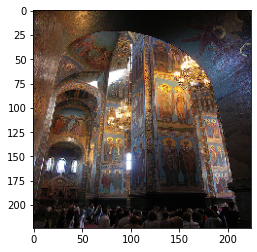

Nuisance image: 
Logits:  [1.4793420e-04 5.2129555e-05 1.2350197e-02 7.6253325e-02 1.6173028e-03
 5.8453064e-03 1.3193559e-02 8.8341957e-01 4.9848668e-04 6.6221124e-03]
Predicted:  7
Real:  7


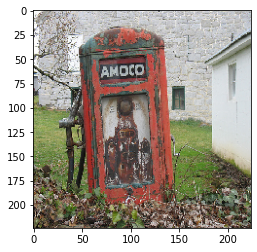

Metameric image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Metameric logits:  [8.5032325e-06 1.3255021e-06 3.4847260e-03 1.5249572e-02 3.0846077e-01
 6.3496507e-03 2.6624463e-02 5.5051655e-01 2.8850930e-03 8.6419344e-02]
Metameric class:  7


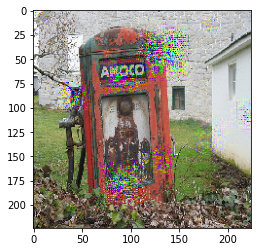

In [17]:
for _ in range(10):
  logit_img, nuisance_img = choose_images(model, test, 0.6)

  nuisance = model.get_nuisance(nuisance_img)
  logits, _ = model(logit_img, training=False)

  print("Metameric image")
  metameric_img = model.get_x(logits, nuisance)
  met_logits, _ = model(np.reshape(metameric_img, (1, *config.input_shape)), training=False)
  print("Metameric logits: ", tf.nn.softmax(met_logits).numpy()[0])
  print("Metameric class: ", np.argmax(tf.nn.softmax(met_logits).numpy()[0]))
  plt.imshow(metameric_img)
  plt.show()
  print()

Посмотрим обратима ли наша сеть, если не заменять логиты и nuisance переменные:

Logit image: 
Logits:  [8.8274987e-08 6.1284453e-07 2.8431565e-05 1.1695903e-04 3.7545830e-03
 5.5279628e-07 2.2645245e-04 7.2232197e-04 2.5040186e-03 9.9264598e-01]
Predicted:  9
Real:  9


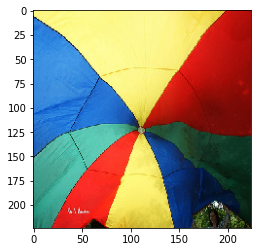

Nuisance image: 
Logits:  [2.1172241e-07 1.4722787e-05 9.9561667e-01 1.1595836e-03 1.1475711e-05
 5.9226095e-05 9.1988244e-04 2.1852322e-03 3.0105226e-05 2.9392434e-06]
Predicted:  2
Real:  2


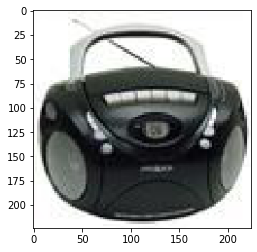

Logit image from logits and logits from image: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Logits:  [8.8285041e-08 6.1288046e-07 2.8432036e-05 1.1697212e-04 3.7550570e-03
 5.5290189e-07 2.2646658e-04 7.2239799e-04 2.5040016e-03 9.9264538e-01]


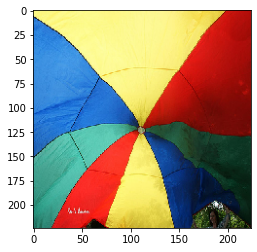

In [18]:
logit_img, _ = choose_images(model, test, 0.6)

nuisance = model.get_nuisance(logit_img)
logits, _ = model(logit_img, training=False)

print("Logit image from logits and logits from image: ")
new_logit_img = model.get_x(logits, nuisance)
new_logits, _ = model(np.reshape(new_logit_img, (1, *config.input_shape)), training=False)
print("Logits: ", tf.nn.softmax(new_logits).numpy()[0])
plt.imshow(new_logit_img)
plt.show()
print()